In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List
from tqdm.notebook import tqdm

In [69]:
class Provider:

    def __init__(self, commission: float, conversion: float, processing_time: float):
        self.commission = commission
        self.conversion = conversion
        self.processing_time = processing_time

    def __repr__(self):
        return f"Коммисия: {self.commission}, Время обработки: {self.processing_time}, Конверсия: {self.conversion}"

In [70]:
providers: List[Provider] = []

for _, row in pd.read_csv("data/providers_1.csv").drop_duplicates(subset=["ID"]).iterrows():
    providers.append(
        Provider(
            commission=row["COMMISSION"],
            conversion=row["CONVERSION"],
            processing_time=row["AVG_TIME"]
        )
    )

for _, row in pd.read_csv("data/providers_2.csv").drop_duplicates(subset=["ID"]).iterrows():
    providers.append(
        Provider(
            commission=row["COMMISSION"],
            conversion=row["CONVERSION"],
            processing_time=row["AVG_TIME"]
        )
    )

In [72]:
def compute_expected_processing_time(chain: List[Provider]) -> float:
    probas, values = [], []

    for k in range(len(chain)):
        multiplication = np.prod([1 - provider.conversion for provider in chain[:k]])

        probas.append(multiplication * chain[k].conversion)

        values.append(np.sum([provider.processing_time for provider in chain[:k + 1]]))

    probas, values = np.array(probas), np.array(values)

    return probas.dot(values)


def compute_expected_conversion(chain: List[Provider]) -> float:
    return 1 - np.prod([1 - provider.conversion for provider in chain])


def compute_expected_commission(chain: List[Provider]) -> float:
    probas, values = [], []

    for k in range(len(chain)):
        multiplication = np.prod([1 - provider.conversion for provider in chain[:k]])

        probas.append(multiplication * chain[k].conversion)
        values.append(chain[k].commission)

    probas, values = np.array(probas), np.array(values)

    return probas.dot(values)

In [73]:
CHAIN_LENGTHS = range(2, len(providers))
N_EXPS = 1000
SEED = 42

#random.seed(SEED)

average_expected_processing_time = []
average_expected_commission = []
average_expected_conversion = []

for chain_length in tqdm(CHAIN_LENGTHS):
    expected_processing_times = []
    expected_commissions = []
    expected_conversions = []
    
    for _ in range(N_EXPS):
        chain = random.sample(population=providers, k=chain_length)
        #chain = sorted(chain, key=lambda p: p.conversion, reverse=True)

        expected_processing_times.append(compute_expected_processing_time(chain))
        expected_commissions.append(compute_expected_commission(chain))
        expected_conversions.append(compute_expected_conversion(chain))

    average_expected_processing_time.append(np.mean(expected_processing_times))
    average_expected_commission.append(np.mean(expected_commissions))
    average_expected_conversion.append(np.mean(expected_conversions))

  0%|          | 0/87 [00:00<?, ?it/s]

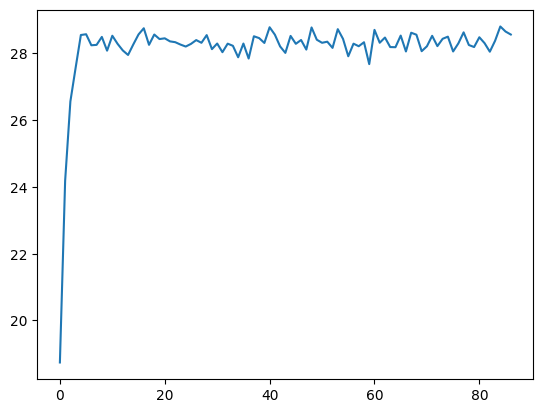

In [92]:
plt.plot(average_expected_processing_time)

In [81]:
payments = pd.read_csv("data/payments_1.csv")

payments.eventTimeRes = pd.to_datetime(payments.eventTimeRes)
payments = payments.sort_values(by="eventTimeRes")


providers = pd.read_csv("data/providers_1.csv")
providers.TIME = pd.to_datetime(providers.TIME)

providers = providers.sort_values(by="TIME")
providers = providers.drop_duplicates(subset=["TIME", "ID"], keep="last")

In [37]:
def get_available_providers(transaction: pd.Series) -> pd.DataFrame:
    mask = (providers.CURRENCY == transaction["cur"]) & \
           (transaction["amount"] >= providers.MIN_SUM) & \
           (transaction["amount"] <= providers.MAX_SUM)
    
    return providers.copy()[mask].drop_duplicates("ID")

In [38]:
lengths = []

for k in tqdm(range(len(payments))):
    available_providers = get_available_providers(payments.iloc[k])

    lengths.append(len(available_providers))

  0%|          | 0/193978 [00:00<?, ?it/s]

In [94]:
providers[providers["TIME"] == "2024-11-24 23:00:00"]

,TIME,ID,CONVERSION,AVG_TIME,MIN_SUM,MAX_SUM,LIMIT_MIN,LIMIT_MAX,LIMIT_BY_CARD,COMMISSION,CURRENCY
80,2024-11-24 23:00:00,45,0.60,10.0,600.0,3000.0,31000.0,1900000.0,-,0.027,PEN
79,2024-11-24 23:00:00,47,0.65,24.0,900.0,4500.0,51000.0,25600000.0,-,0.050,PEN
78,2024-11-24 23:00:00,35,0.60,16.0,200.0,4000.0,1000.0,38200000.0,-,0.015,GHS
77,2024-11-24 23:00:00,34,0.55,26.0,900.0,5000.0,61000.0,31300000.0,-,0.050,GHS
76,2024-11-24 23:00:00,36,0.50,14.0,500.0,5000.0,71000.0,27600000.0,-,0.030,GHS
75,2024-11-24 23:00:00,29,0.50,10.0,700.0,7500.0,71000.0,4200000.0,-,0.045,USD
74,2024-11-24 23:00:00,33,0.60,22.0,600.0,8500.0,71000.0,31100000.0,-,0.045,USD
72,2024-11-24 23:00:00,28,0.60,20.0,400.0,4000.0,11000.0,5600000.0,-,0.015,MYR
66,2024-11-24 23:00:00,10,0.55,14.0,900.0,4000.0,41000.0,36300000.0,-,0.045,TRY
70,2024-11-24 23:00:00,23,0.70,24.0,600.0,7000.0,11000.0,5600000.0,-,0.015,JPY


In [68]:
payments

,eventTimeRes,amount,cur,payment,cardToken
193977,2024-11-24 21:00:00,700.00,RUB,c77be33e8db2f5352ebbc0a1b3f10e3e,336d5ebc5436534e61d16e63ddfca327
193972,2024-11-24 21:00:01,945.90,RUB,c9a03cbbe592f930d52416b049bc1d1a,336d5ebc5436534e61d16e63ddfca327
193973,2024-11-24 21:00:01,90.00,BRL,f3adde51de36a39508d11d4bf4a98edc,336d5ebc5436534e61d16e63ddfca327
193976,2024-11-24 21:00:01,180.00,BRL,0ab79b6d41d6e887e84ec4a85ea33733,336d5ebc5436534e61d16e63ddfca327
193975,2024-11-24 21:00:01,35.00,BRL,90a88e0d5b6bfff12909878f265cc2f4,336d5ebc5436534e61d16e63ddfca327
...,...,...,...,...,...
4,2024-11-25 20:59:58,8.00,AZN,4af690ba4eebb6d4782d9a3051dc58d2,373e0a66a63b8661f10afd098c68aeab
3,2024-11-25 20:59:58,27.27,AZN,c30b3850e85454145bcb0dda3d209d88,61e3567ab56a79911fb7bcc0cc13db64
2,2024-11-25 20:59:58,2000.00,RUB,0e2705d1083b67f2c5ea12de3b7ab182,a3481a01b54d0c96dd44200389888bc6
1,2024-11-25 20:59:58,2700.00,RUB,6eb49e22afdd28083ff82cdff8068880,774d551c9fff62fbac6c4ef424af0446
